In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)


# Case 3: Data-driven approaches for revenue management

You are expected to contribute to the topic from three perspectives bringing together insights from the course material on optimization and data analysis.



## Question 1 - Static Policies

### a) Protection levels
We discussed protection levels as a means to trade off base utilization from low cost bookings against flexible bookings by high value customers. We want to explore this practice in the data by doing the following:

* We limit the analysis on the city hotel and only consider bookings that took place, had two adults, meal = BB and took at most 3 nights
* We split the data as follows: all bookings with lead time less than 2 weeks are spontaneous (high-value bookings), the remaining are low-value long-term bookings
* Use the average ADR for the two segments as the value

Our dataset features bookings over the course of 2 years. How can you come up with the nightly arrival rate of the spotaneous bookings as defined above?

Assume a poisson distribution and execute the protection level analysis as in the lecture assuming a hotel size of 30.


### b) Overbooking

Allocating more rooms than actually available is a common appraoch to cope with cancellations in the hospitality industry. The model we discussed trades off penalty payments in case of more demand having maternalized vs. extra revenues from overbooked demand. This is a natural for the dataset at hand but we need to be careful which offers access to frequency of cancellations as well as rates. At the same time penalty payments / goodwill remains unsepcified. For this reason we expect you to do the following:

* Establish a meaningful analysis scenario to harmonize the data you calibrate the model on (as we did in question a). You can pick the hotel size as you like.
* Estimate the historical cancellation rate, average ADR and demand level for your scenario.
* Determine the optimal overbooking levels for varying level of goodwill (e.g., ADR * 1.5 through ADR * 3) and visualize the obtained penalty-overbooking relationship.

You may try to expand the previous analysis to cover richer settings. Ideas that you could explore include (but are nor restricted to) the following:

* Accounting for quarterly patterns of ADR and cancellation rates (periodic adjustment of policies)
* Replacing booking class by a an ADR threshold which has to be optimized. Use the data to obtain a distribution of the rates and come up with a meaningful way to incorporate it into the stochastic program scenarios.

## Question 2 - Dynamic Policy

In the lecture we briefly introduced the minimal simulation framework below. Note this is an updated version which also provides the opportunity to run a parameter search across a value. For the case study you are expected to contribute in two ways:

* Create an optimized logic which adapts the protection level dynamically each simulation step by observing hotel utilization / realized arrivals of high and low demand. HINT: You probably want to rerun an optimization each turn which optimizes a respectively smaller hotel. Can you improve the results?
* Integrate cancellations as an additional random arrival and see if you can also include overbooking in the simulation.

You may also consider the following extra analyses:

* Creating a simulation on top a strip of the real data: taking some data for calibration and then use the remaining data to play out the arrival and cancellations of bookings. Again you will have to come up with a meaningful scenario yourself.
* Are you still able to find good dynamic policies? Comment on the difficulties going from the stylized model to the real data.

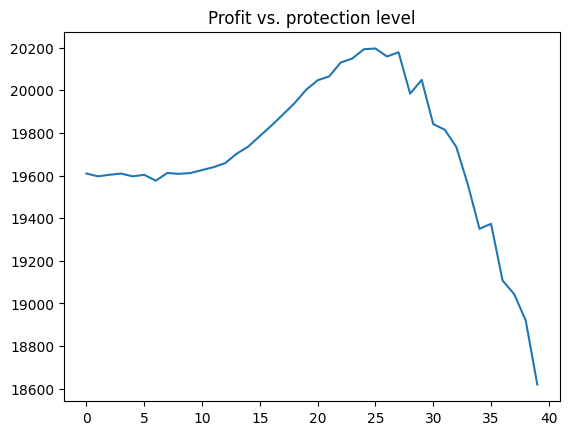

In [3]:
# Parameters
total_rooms = 118
low_fare = 159
high_fare = 225
time_horizon = 30  # days booking horizon

mean_demand_high_fare_daily = 27.3 / time_horizon  # Daily mean demand for high fare
mean_demand_low_fare_daily = 118 * 2 / time_horizon  # High probability to exceed 118 over 30 days
num_simulations = 500  # Number of simulations

def simulate_booking(protection):
    # Static booking limits from earlier calculations
    optimal_high_fare_rooms = protection  # Approximation of earlier result
    optimal_low_fare_rooms = total_rooms - optimal_high_fare_rooms

    high_fare_bookings = np.zeros(time_horizon)
    low_fare_bookings = np.zeros(time_horizon)
    daily_profit = np.zeros(time_horizon)

    cumulative_high_fare_bookings = 0
    cumulative_low_fare_bookings = 0
    cumulative_profit = 0

    for t in range(time_horizon):
        # INCLUDE UPDATE LOGIC FOR PROTECTION LIMIT HERE

        # Simulate arrivals
        high_fare_arrivals = np.random.poisson(mean_demand_high_fare_daily)
        low_fare_arrivals = np.random.poisson(mean_demand_low_fare_daily)

        # Prioritize high fare bookings
        available_rooms = total_rooms - cumulative_high_fare_bookings - cumulative_low_fare_bookings
        bookings_high = min(high_fare_arrivals, available_rooms)
        cumulative_high_fare_bookings += bookings_high

        # Update available rooms after high fare bookings
        available_rooms = min(total_rooms - cumulative_high_fare_bookings - cumulative_low_fare_bookings, optimal_low_fare_rooms-cumulative_low_fare_bookings)
        bookings_low = min(low_fare_arrivals, available_rooms)
        cumulative_low_fare_bookings += bookings_low

        # Calculate daily profit
        profit = bookings_high * high_fare + bookings_low * low_fare
        cumulative_profit += profit

        # Store daily results
        high_fare_bookings[t] = cumulative_high_fare_bookings
        low_fare_bookings[t] = cumulative_low_fare_bookings
        daily_profit[t] = cumulative_profit

    return high_fare_bookings, low_fare_bookings, daily_profit

# Run simulations
results = {}
all_high_fare_bookings = {}
all_low_fare_bookings = {}
all_daily_profits = {}

for protection in range(40):
    all_high_fare_bookings[protection] = []
    all_low_fare_bookings[protection] = []
    all_daily_profits[protection] = []
    for _ in range(num_simulations):
        high_fare_bookings, low_fare_bookings, daily_profit = simulate_booking(protection)
        all_high_fare_bookings[protection].append(high_fare_bookings)
        all_low_fare_bookings[protection].append(low_fare_bookings)
        all_daily_profits[protection].append(daily_profit)
    profit = sum([all_daily_profits[protection][i][-1] for i in range(num_simulations)])/num_simulations
    results[protection] = profit

myList = sorted(results.items())
x, y = zip(*myList)

plt.plot(x, y)
plt.title('Profit vs. protection level')
plt.show()

## Question 3 - Prescriptive Model

We now want to combine the predictive model obtained from applying machine learning on the data with a stochastic overbooking program. The code below is scaffold to fit an XGBoost model to a 80-20 train test split of the data. Subsequently the `predictions` list reveals the predicted cancellation probabilities for each observation.

Please combine this object with a Linear Program as follows:

- Choose a scenario (which hotel, which week) and retrieve all relevant bookings
- You can proceed focusing on a single night and assume that the retrieved bookings will apply.
- Obtain the cancelation probability for each of these bookings using the predictive model below.
- Create a set of scenarios (around 10 should be a good start) by independently sampling cancellation yes / no for each booking based on the probabilities. HINT: You draw random numbers from uniform (0,1) and check if they are smaller than the probability prediction.
- Set up a linear program which optimizes the expected profit (revenues - goodwill) from accepting / rejecting the bookings.

Quantify your model's overbooking tedency.

XGB_model accuracy_score: 0.845


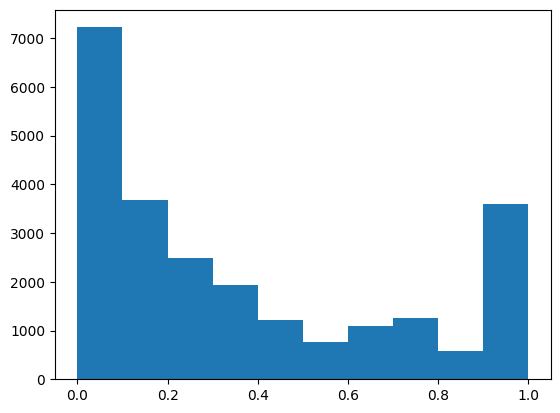

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# We are dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

full_data_cln.shape

rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data_cln.drop(["is_canceled"], axis=1)[features]
y = full_data_cln["is_canceled"]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

model = [("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in model:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    model_steps.fit(X_train, y_train)
    preds = model_steps.predict(X_test)
    score = accuracy_score(y_test, preds)
    print(f"{name} accuracy_score: {round(score, 4)}")

predictor = Pipeline(steps=[('preprocessor', preprocessor), ('model',model)])
predictions = [item[1] for item in predictor.predict_proba(X_test)]

plt.hist(predictions);